<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/text_similarity_datasource/text-similarity/text_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load the medium-sized model
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
import numpy as np
import scipy
import spacy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.style.use('seaborn-whitegrid')

In [0]:
# load the english language model
# this includes: tokenizer, tagger, parser, named-entity recogniser, and word vectors
nlp = spacy.load("en_core_web_md")

## Word vectors

Like a dictionary for machines

In [4]:
# try it out with some text, we'll try a real text later.
tokens = nlp("man woman king queen")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov, token.vector)

man True 6.352939 False [-1.7310e-01  2.0663e-01  1.6543e-02 -3.1026e-01  1.9719e-02  2.7791e-01
  1.2283e-01 -2.6328e-01  1.2522e-01  3.1894e+00 -1.6291e-01 -8.8759e-02
  3.3067e-03 -2.9483e-03 -3.4398e-01  1.2779e-01 -9.4536e-02  4.3467e-01
  4.9742e-01  2.5068e-01 -2.0901e-01 -5.8931e-01  6.1615e-02  1.0434e-01
  2.4424e-01 -2.9120e-01  3.0746e-01  3.6276e-01  7.1151e-01 -8.0523e-02
 -5.9524e-01  3.4834e-01 -3.3048e-01  7.0316e-02  5.3329e-01 -2.9081e-01
  1.3459e-01 -3.9856e-01 -3.2435e-01  1.1867e-01 -1.4938e-01 -3.8256e-01
  3.3116e-01 -3.1488e-01 -9.4491e-02 -6.1319e-02  1.5518e-01 -2.5523e-01
 -1.1813e-01  2.5296e-01 -9.5174e-02 -1.6596e-01 -1.0840e-01  8.8803e-02
  2.0890e-01  4.3981e-01  1.0476e-03 -4.0666e-02  2.6487e-01 -6.1009e-01
 -1.4405e-01 -8.1185e-02  7.5475e-03  2.3373e-01 -2.7772e-02 -2.9315e-01
 -1.1744e-01 -8.3193e-02 -2.3768e-01  1.5735e-01 -5.6408e-01 -2.9323e-01
  1.6387e-02 -7.8160e-02 -2.1301e-01 -1.7845e-01 -3.0769e-01 -4.6203e-01
 -2.5220e-03  4.2973e-01 -4

In [5]:
# plot the word vectors in 2-D space

# doing a bit of list comprehension to get the vectors
# then dumping it into a numpy array
vectors = np.array([token.vector for token in tokens])

vectors.shape

(4, 300)

In [6]:
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# each of these are 2 dimensions
vectors_2d

array([[ -32.147305, -293.99146 ],
       [-114.43374 ,  -16.287865],
       [-309.85068 , -376.27866 ],
       [-392.13712 ,  -98.57503 ]], dtype=float32)

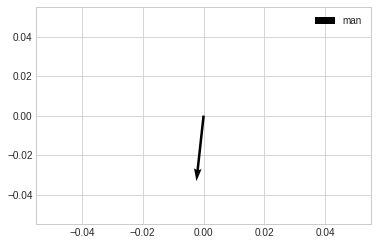

In [7]:
# here's one vector
plt.quiver([0], [0], vectors_2d[0, 0], vectors_2d[0, 1], 
           label=tokens[0].text,
           scale=1500) 
plt.legend()
plt.show()

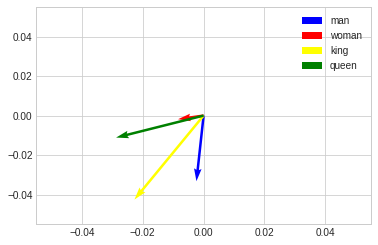

In [8]:
# let's plot all of them

colours = ['blue', 'red', 'yellow', 'green']

for i in range(len(tokens)):
  plt.quiver([0], [0], vectors_2d[i, 0], vectors_2d[i, 1], 
             label=tokens[i].text,
             scale=1500,
             color=colours[i])

plt.legend()
plt.show()

## Measuring similarity

We can measure the similarity (cosine similarity) of two word vectors.

Nearer to 1: more similar

Nearer to 0: less similar 

In [14]:
# Explore more word vectors

# create a dictionary
word_to_token = { token.text : token for token in tokens }
word_to_token

{'king': king, 'man': man, 'queen': queen, 'woman': woman}

In [17]:
word_to_token['queen'].similarity(word_to_token['woman'])

0.40660653

In [18]:
word_to_token['king'].similarity(word_to_token['man'])

0.4088461

In [16]:
word_to_token['king'].similarity(word_to_token['woman'])

0.26556593

In [19]:
word_to_token['man'].similarity(word_to_token['woman'])

0.7401745

### Dot product between two vectors also gives the measure of similarity

Larger value: more similar

Smaller value: less similar

In [23]:
np.dot(word_to_token['queen'].vector, word_to_token['woman'].vector)

19.15795

In [21]:
np.dot(word_to_token['man'].vector, word_to_token['woman'].vector)

32.439884

In [22]:
np.dot(word_to_token['king'].vector, word_to_token['woman'].vector)

13.084201

## Application: How much does a text match topics of interest

1. Take any text
2. Tokenise it into words
3. Get the list of word vectors
4. Do a dot product with each topic keyword
5. Rank the dot products to find out the highest matching keywords

Q: what are the advantages over simple string search / matching?